[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KDSource/KDSource/blob/master/docs/tutorial/tutorial.ipynb)

# Tutorial

This tutorial shows the basic usage of the KDSource tool.

The starting point is a particle list recorded somewhere in a Monte Carlo simulation, e.g. when passing through a given surface. In this example we will use a sample list of 1000 particles forming a flat source.

We will then fit a KDE source on the particle list using the KDSource class, and save the optimized model as a KDSource XML file. This model represents a distributional source which has the estimated distribution of the particle list.

Finally, we will use the KDSource XML file to generate an arbitrary number of new particles, following the estimated distribution of the original particle list. They will be saved into a new MCPL file, from which they can be converted to several Monte Carlo formats.

Let's get to it!

## Install KDSource

First of all, we install KDSource on the Google Colab virtual machine. Estimated time: 1 min

Skip this cell if KDSource is already installed and available in your PATH (installation instructions [here](https://kdsource.readthedocs.io/en/latest/installation.html)).

In [ ]:
def install_kdsource():
    #
    # Clone source code from Github, make and install
    #
    
    import os
    
    if not os.path.isdir('/content'):
        print("This function installs KDSource in a Google Colaboratory instance.")
        print("For local installation instructions see:")
        print("https://kdsource.readthedocs.io/en/latest/installation.html")
        return
    
    %cd -q /content
    print("Obtaining KDSource source code from Github...")
    !git --no-pager clone --recurse-submodules https://github.com/KDSource/KDSource &> /dev/null
    %cd -q KDSource
    !git --no-pager checkout master &> /dev/null
    !mkdir build
    %cd -q build
    print("Running cmake...")
    !cmake .. -DCMAKE_INSTALL_PREFIX=/usr/local/KDSource &> /dev/null
    print("Running make install...")
    !make install &> /dev/null
    print("Installing Python API...")
    %cd -q ../python
    !pip install . &> /dev/null
    
    os.environ['PATH'] += ":/usr/local/KDSource/bin"
    
    %cd -q /content

from time import time
t1 = time()
install_kdsource()
t2 = time()
print("Installed KDSource in {:.2f} minutes".format((t2-t1)/60.0))


## Import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

import kdsource as kds   # KDSource Python API
import mcpl              # MCPL Python API

## Load and inspect the particle list

The sample particle list is recorded as a MCPL file called `surf_source.mcpl.gz`, in the same folder than this Notebook, `docs/tutorial`. With the MCPL Python library we can load it and get basic statistical info and histograms.

------------------------------------------------------------------------------
nparticles   : 1000
sum(weights) : 1000
------------------------------------------------------------------------------
             :            mean             rms             min             max
------------------------------------------------------------------------------
ekin   [MeV] :     0.000361218       0.0106419      9.0346e-10         0.33598
x       [cm] :       -0.365777         12.8653        -25.0362         24.9793
y       [cm] :     -0.00507184         12.3372         -25.257          25.265
z       [cm] :    -1.60664e-05      0.00281836     -0.00592316      0.00600731
ux           :     -0.00910573        0.387815       -0.955377        0.969421
uy           :     -0.00360428        0.398127       -0.983487         0.98415
uz           :        0.803049        0.214733        0.109885        0.999961
time    [ms] :         3.23441         2.26512      0.00019913          17.918
weight      

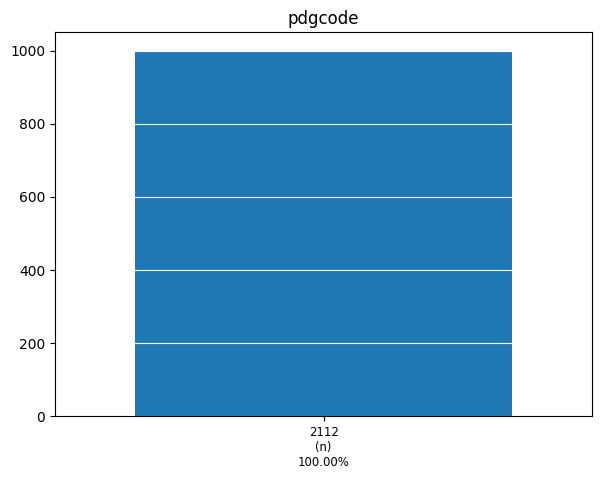

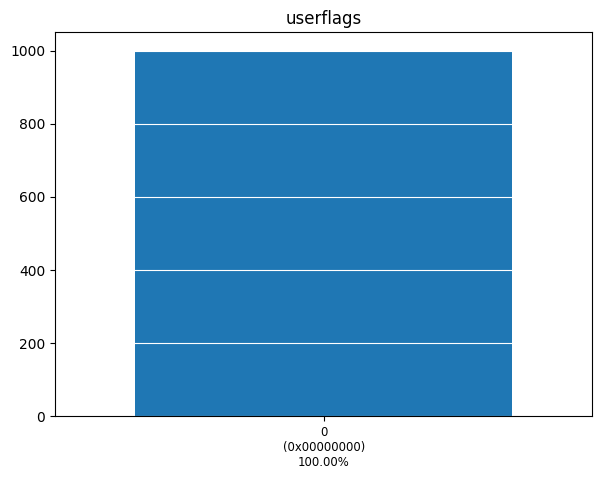

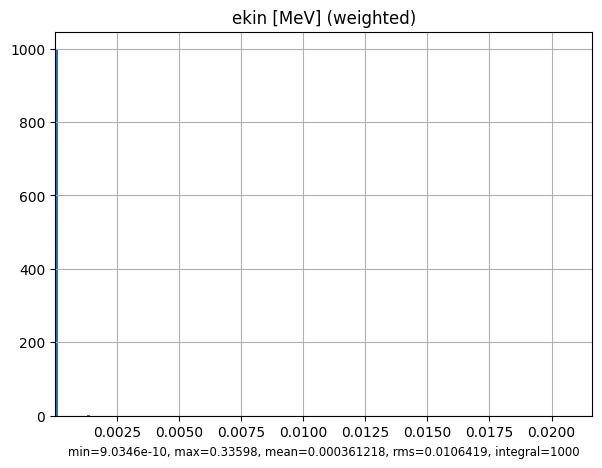

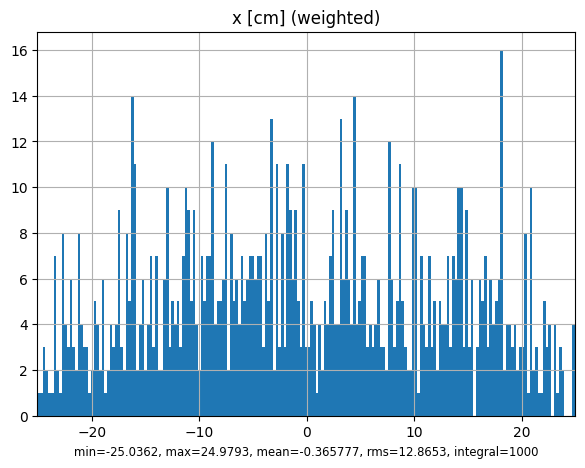

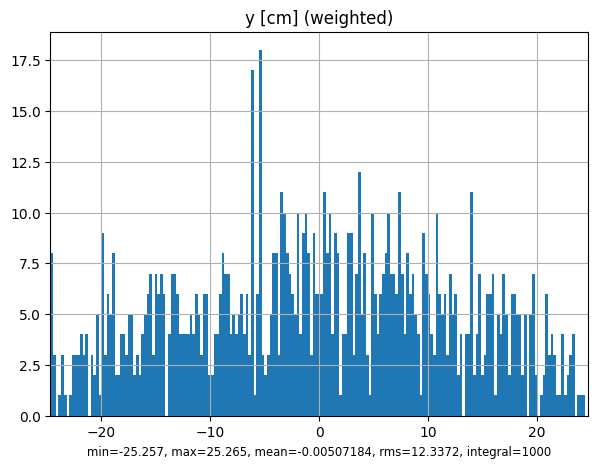

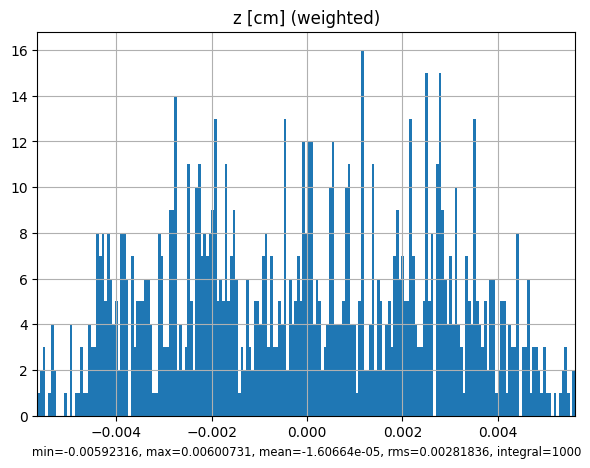

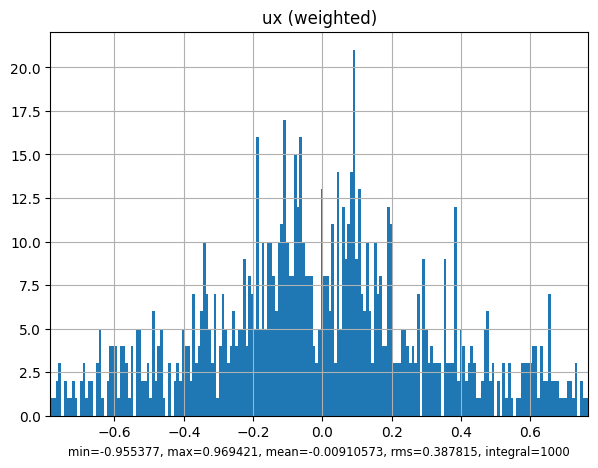

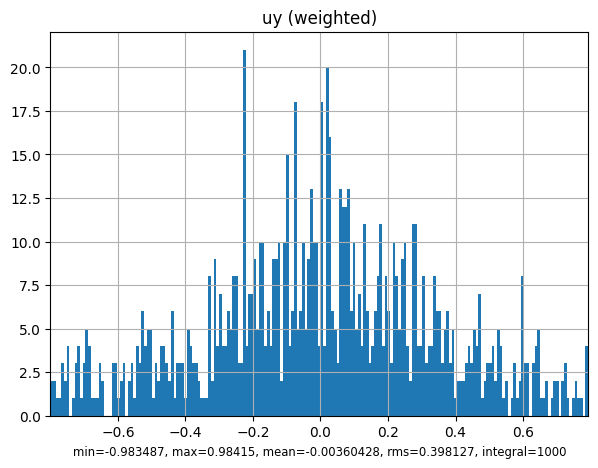

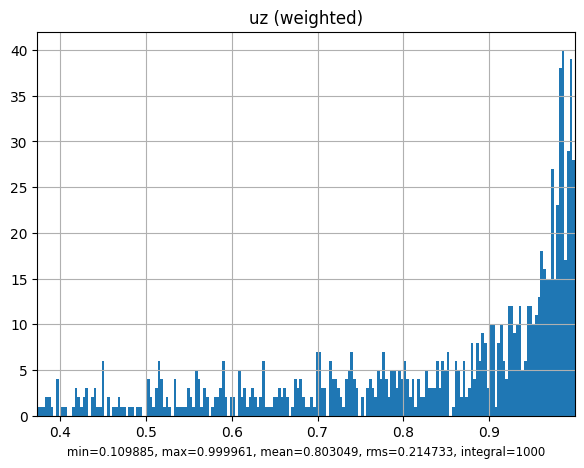

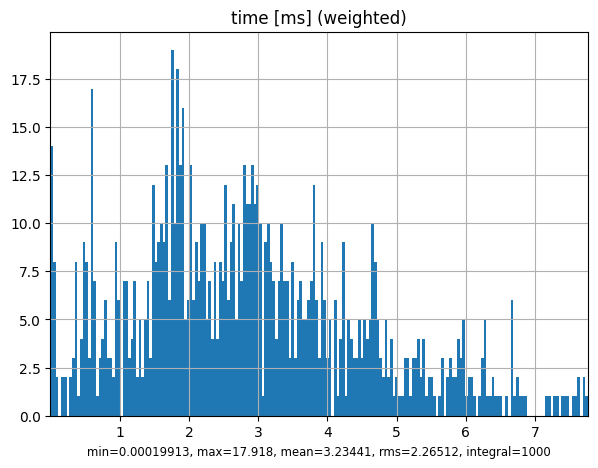

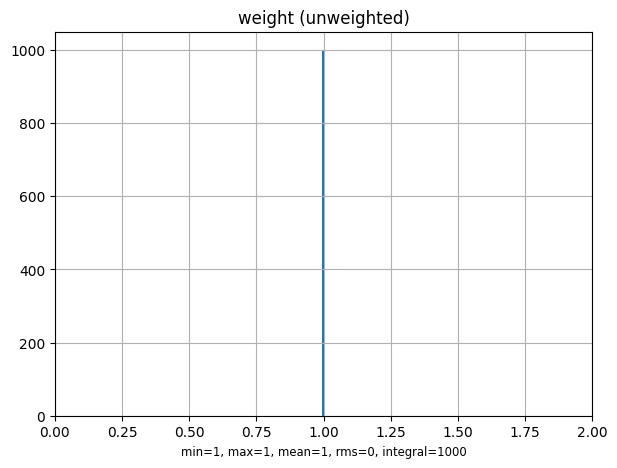

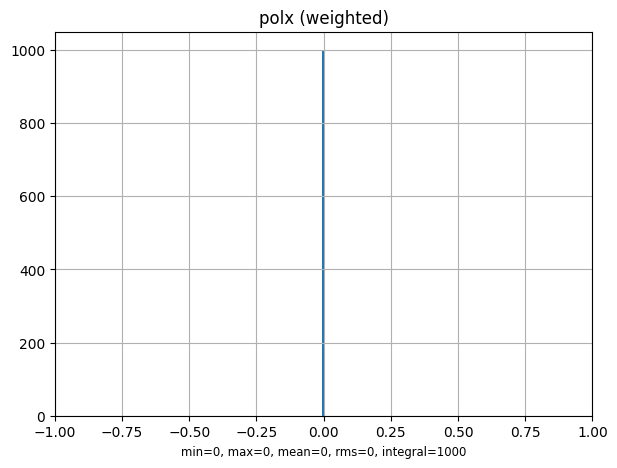

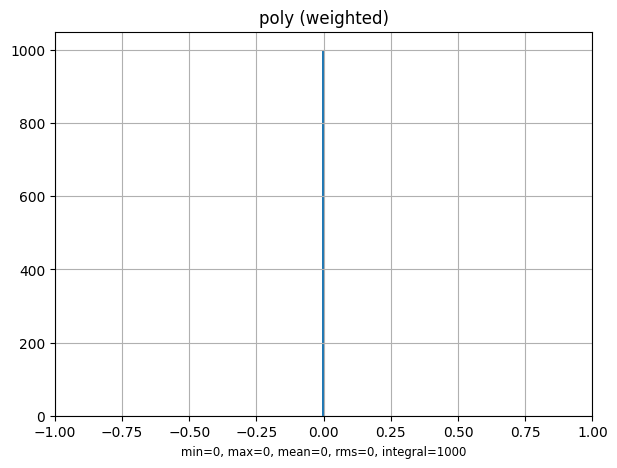

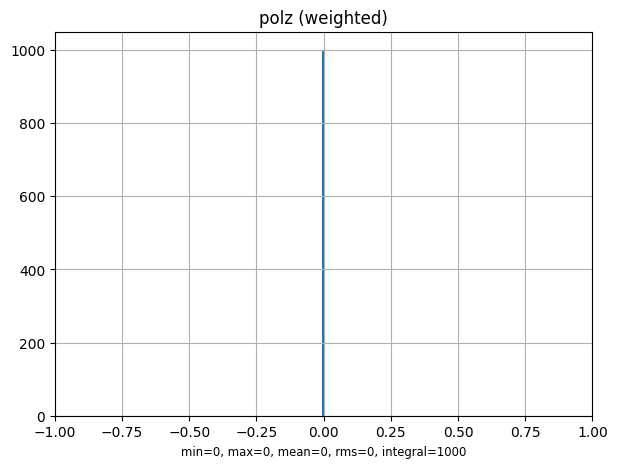

In [4]:
# Plot using the MCPL library

surf_source = "surf_source.mcpl.gz"
mcpl.dump_stats(mcpl.collect_stats(surf_source))
mcpl.plot_stats(surf_source)

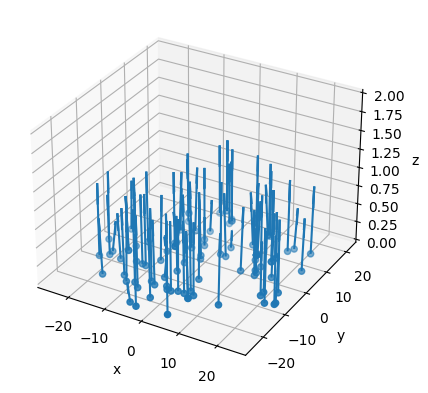

In [5]:
# Plot 3D positions and directions with Matplotlib 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim(0,2)

mcplsource = mcpl.MCPLFile(surf_source, blocklength=100)
block = mcplsource.read_block()

ax.scatter(*block.position.T)
ax.quiver(*np.array(block.position.T), *block.direction.T)
plt.show()

As we can see, the source lies in the XY plane, and particles travel towards the positive z direction.

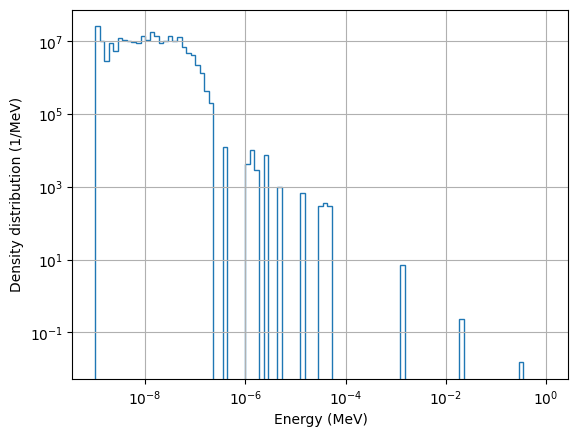

In [9]:
# Plot energy histogram

bins = np.logspace(-9, 0, 100)

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])

plt.stairs(hist, edges=bins)

plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (MeV)")
plt.ylabel("Density distribution (1/MeV)")
plt.show()

As we can see, the particle list statistics are quite poor. The thermal spectrum is well defined, but the epithermal and fast regions can barely be distinguished.

## Create and optimize KDSource

In this section we will create a KDSource object and fit the KDE source model to the generated particle list, i.e., optimize its bandwidth.

The KDSource tool uses the Adaptive Multivariate Kernel Density Estimator to estimate the source density:
$$
	\hat{f}(\textbf{x}) = \hat{f}(x_{1},x_{2},...,x_{D}) =
	\sum \limits_ {\rm i=1}^{N} w_{\rm i} \left
	\{\prod_{\rm j=1}^{D}\frac{1}{h_i}
	K\left(\frac{x_{\rm j}-(p_{\rm i})_{\rm  j}}{s_j h_i}\right) \right \} 
	\label{eq:multiD}
$$

Where:
* $x$ is the phase-vector defining a source particle (with optional changes of variables).
* $p_i$ is the i-th particle in the particle list.
* $w_i$ is the weight corresponding to the i-th particle in the particle list.
* $K$ is the kernel function (standard gaussian).
* $h_i$ is the bandwidth corresponding to the i-th particle in the particle list.
* $s_j$ is the scaling factor for variable $j$, which by default is the standard deviation of the component $j$ of the particle list. 

### Create KDSource

In [10]:
# PList: wrapper for MCPL file
plist = kds.PList(surf_source)
# Geometry: define changes of variables
geom = kds.Geometry([kds.geom.Lethargy(),
                     kds.geom.SurfXY(),
                     kds.geom.Isotrop()])
# Create KDSource
s = kds.KDSource(plist, geom)

Using existing file surf_source.mcpl.gz
sum_weights = 1000.0
p2 = 1000.0
N = 1000
N_eff = 1000.0


### Optimize bandwidth

Before bandwidth optimization, we can optionally set variable importances. Setting a value greater than one for a given variable improves the quality of the estimation along that dimension, at the expense of a coarser estimation on the other variables.

In this example we will set a higher importance to the energy.

In [38]:
# Set importances
var_importance = [2,1,1,1,1,1]

# Calculate scalings as std / var_imp
parts,ws = s.plist.get(N=-1)
scaling = s.geom.std(parts=parts)
scaling /= var_importance

Number of particles to use for fitting.

We will use -1, which means use all particles in the list.

In [39]:
N = -1

There are 3 available bandwidth optimization methods. Choose one and run its cell to optimize bandwidth.

Recommended method is Method 3 (adaptive MLCV).

* Method 1: Silverman's Rule: Simple and fast method.

    BW is chosen based on only on the number of particles, and dimension of geometry.
    
    Estimated time: 1 sec

In [13]:
s.bw_method = "silv"
s.fit(N, scaling=scaling)

Using 1000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.23095974 6.01612221 5.76915213 0.16941985 0.16941985 0.16941985]]


* Method 2: Non-adaptive Maximum Likelihood Cross-Validation: Intermediate method
    
    Creates a grid of bandwidths and evaluates the MLCV Figure of Merit (FoM) on each one. Selects the bandwidth that optimizes CV score.
    
    Estimated time: 1 min

Using 1000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


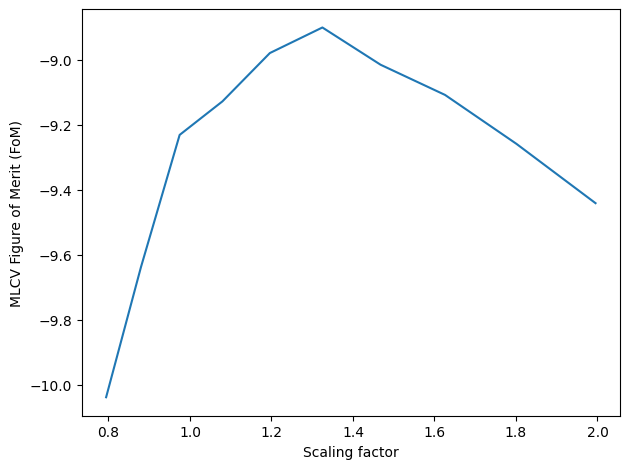

Done
Optimal bw (mlcv) = [[0.30602613 7.97147837 7.64423823 0.22448458 0.22448458 0.22448458]]
Using 1000 particles for fit.


In [11]:
s.bw_method = "mlcv"
seed = None # Default: Use the Silverman's Rule as seed
grid = np.logspace(-0.1,0.3,10)

N_cv = int(1E4) # Use a smaller N to reduce computation times
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)

bw = s.kde.bw
dim = s.geom.dim
bw *= kds.kde.bw_silv(dim,N)/kds.kde.bw_silv(dim,N_cv) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw) # Create new KDSource with adapted BW
s.fit(N=N, scaling=scaling)

* Method 3: Adaptive Maximum Likelihood Cross-Validation: Most precise method, but also longest to compute.
    
    Uses kNN is to generate a seed adaptive bandwidth. Then creates a grid of adaptive bandwidths by scaling the seed bandwidth, and evaluates the MLCV Figure of Merit (FoM) on each one. Selects the bandwidth that optimizes CV score.
    
    Estimated time: 3 min

Using 1000 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 1.0
batch = 1 / 1
Done
Optimal bw (knn) = [[ 0.52424503  9.10381498  8.73009087  0.25637229  0.25637229  0.25637229]
 [ 0.48304398  8.38833522  8.04398254  0.23622368  0.23622368  0.23622368]
 [ 0.87480743 15.19153189 14.56789863  0.42780831  0.42780831  0.42780831]
 ...
 [ 0.78290061 13.59551725 13.0374026   0.38286299  0.38286299  0.38286299]
 [ 0.83341037 14.47264823 13.87852614  0.40756385  0.40756385  0.40756385]
 [ 0.85813582 14.90201974 14.29027136  0.41965537  0.41965537  0.41965537]]
Using 1000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


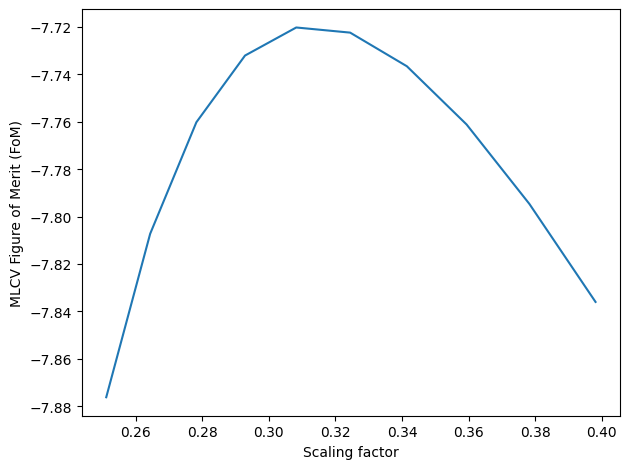

Done
Optimal bw (mlcv) = [[0.16159325 2.80615924 2.69096255 0.07902417 0.07902417 0.07902417]
 [0.14889344 2.58561981 2.47947657 0.07281357 0.07281357 0.07281357]
 [0.26965058 4.68263663 4.49040797 0.1318676  0.1318676  0.1318676 ]
 ...
 [0.24132122 4.1906812  4.01864798 0.11801366 0.11801366 0.11801366]
 [0.25689035 4.46104799 4.27791584 0.12562745 0.12562745 0.12562745]
 [0.26451172 4.59339743 4.40483216 0.12935454 0.12935454 0.12935454]]
Using 1000 particles for fit.


In [40]:
# kNN bandwidth
s.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
s.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = s.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
s.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-0.6,-0.4,10)
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = s.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = s.geom.dim
bw_knn_cv *= kds.kde.bw_silv(dim,len(bw_knn))/kds.kde.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw_knn_cv) # Create new KDSource with full BW
s.fit(N=N, scaling=scaling)

## Save KDSource model

We now save our optimized model as a KDSource XML file.

The XML file will contain the KDSource model parameters, and the path to the original particle list MCPL file.

If an adaptive bandwidth was chosen, the list of bandwidths will be saved as a separate binary file and its path will be included in the KDSource XML file. 

In [41]:
xmlfile = "source.xml" # KDSource XML file name

s.save(xmlfile) # Save KDSource to XML file
if os.name == 'posix':
    !cat $xmlfile
if os.name == 'nt':
    !type $xmlfile

Bandwidth file: surf_source_bws
Successfully saved parameters file source.xml
<?xml version="1.0" ?>
<KDSource>
	<J units="1/s">1.0</J>
	<PList>
		<pt>n</pt>
		<mcplname>/media/inti/Disco local/Users/Osiris Inti Abbate/Documents/Universidad/KDSource/KDSource/docs/tutorial/surf_source.mcpl.gz</mcplname>
		<trasl/>
		<rot/>
		<x2z>0</x2z>
	</PList>
	<Geom order="3">
		<Lethargy>
			<dim>1</dim>
			<params nps="1">10</params>
		</Lethargy>
		<SurfXY>
			<dim>2</dim>
			<params nps="5">-inf inf -inf inf 0</params>
		</SurfXY>
		<Isotrop>
			<dim>3</dim>
			<params nps="3">0 0 0</params>
		</Isotrop>
		<trasl/>
		<rot/>
	</Geom>
	<scaling> 0.74085044 12.86529204 12.33715413  0.36229914  0.36229914  0.36229914</scaling>
	<BW variable="1">/media/inti/Disco local/Users/Osiris Inti Abbate/Documents/Universidad/KDSource/KDSource/docs/tutorial/surf_source_bws</BW>
</KDSource>


## Generate particles

We can start generating particles!

Using the command `kdtool resample` we can generate an arbitrary number of particles following the estimated source distribution and save them in a new MCPL file.

For example, let's create 10^6 particles (a lot more than the original 1000).

In [42]:
N_resampled = 1E6 # Number of particles to generate with virtual KDE source

if os.name == 'posix':
    !kdtool resample "$xmlfile" -o "resampled" -n $N_resampled
if os.name == 'nt': # kdtool still not implemented in Windows, call kdtool-resample directly
    !kdtool-resample "$xmlfile" -o "resampled" -n $N_resampled
resampled = "resampled.mcpl.gz"

Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file resampled.mcpl with gzip
MCPL: Succesfully compressed file into resampled.mcpl.gz
Successfully sampled 1000000 particles.


A new MCPL file has been created, named "resampled.mcpl.gz", with particles generated from the KDE-based distribution.

## Create plots

We now want to compare the estimated distribution with the original true distribution, to verify they match. 

We will therefore compare the histograms of the resampled particles with the original particle list.

### Energy plots

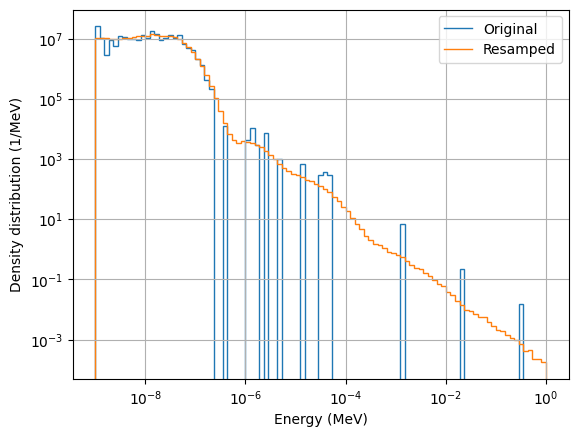

In [43]:
# Plot energy distribution

bins = np.logspace(-9, 0, 100)

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original")

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped")

plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (MeV)")
plt.ylabel("Density distribution (1/MeV)")
plt.legend()
plt.show()

It can be seen that the histogram of the generated particles successfully estimate the original distribution.

Furthermore, we can compare the correlation of the energy spectrum with another variable, for example $\mu=cos(\theta)$, with $\theta$ being the angle between the direction and the $z$ axis.

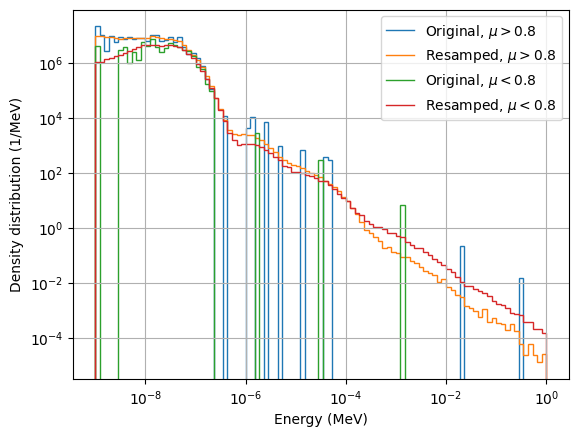

In [44]:
# Plot energy correlation with mu

bins = np.logspace(-9, 0, 100)
mu_crit = 0.8

# mu > mu_crit

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin[pb.uz > mu_crit]
    weights = pb.weight[pb.uz > mu_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original, $\mu > $"+str(mu_crit))

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin[pb.uz > mu_crit]
    weights = pb.weight[pb.uz > mu_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped, $\mu > $"+str(mu_crit))

# mu < mu_crit

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin[pb.uz < mu_crit]
    weights = pb.weight[pb.uz < mu_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original, $\mu < $"+str(mu_crit))

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ekin[pb.uz < mu_crit]
    weights = pb.weight[pb.uz < mu_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped, $\mu < $"+str(mu_crit))

plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (MeV)")
plt.ylabel("Density distribution (1/MeV)")
plt.legend()
plt.show()

It turns out that particles with $\mu>0.8$ have a higher cold spectrum, and that correlation is correctly captured by the KDSource model. On the other side, the resampled curves show a slightly higher epithermal spectrum for $\mu<0.8$, although this can hardly be observed for the original particle list.

### Position plots

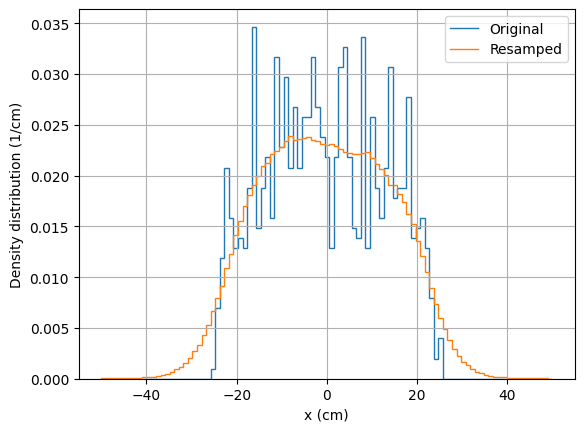

In [53]:
# Plot x distribution

bins = np.linspace(-50, 50, 100)

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.x
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original")

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.x
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped")

plt.grid()
plt.xlabel("x (cm)")
plt.ylabel("Density distribution (1/cm)")
plt.legend()
plt.show()

We observe again that both the KDE curve and the histogram of resampled particles follow the original distribution, although the KDE shows a noticeable softening of the distribution. The $x$ estimated distribution is coarser than the estimated energy spectrum because of the bigger importance factor choosen for the energy distribution before fitting the KDE model. 

### Direction plots

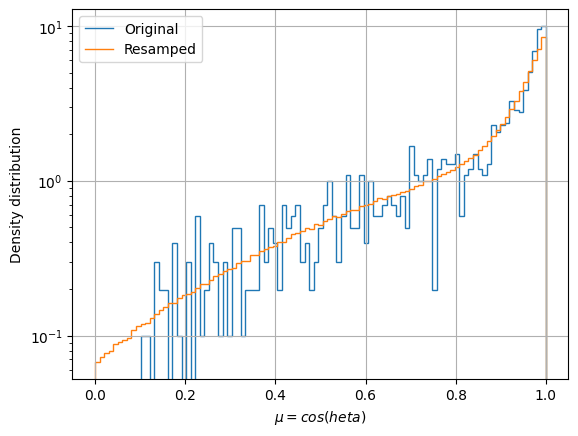

In [52]:
# Plot mu distribution

bins = np.linspace(0, 1, 100)

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.uz
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original")

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.uz
    weights = pb.weight
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped")

plt.grid()
plt.yscale("log")
plt.xlabel("$\mu=cos(\theta)$")
plt.ylabel("Density distribution")
plt.legend(loc="upper left")
plt.show()

In the case of the $\mu$ distribution, although the general distribution is correctly estimated, the is a certain underestimation around $\mu=1$. The underestimation of the distribution at peaks (and overestimation at valleys) is a charasteristic bias of any softening method like KDE. The adaptive bandwidth helps handling the issue, although is does not eliminates it. 

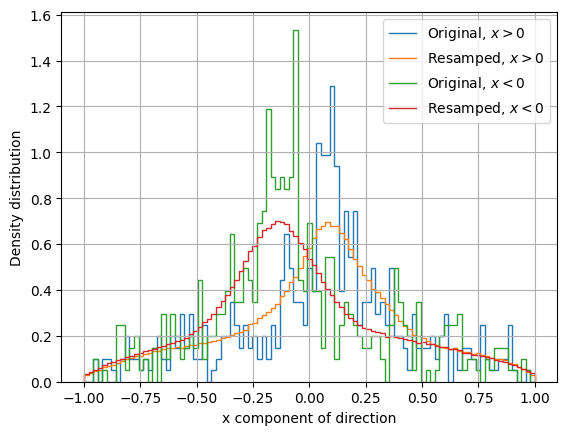

In [55]:
# Plot ux correlation with x

bins = np.linspace(-1, 1, 100)
x_crit = 0

# x > x_crit

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ux[pb.x > x_crit]
    weights = pb.weight[pb.x > x_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original, $x > $"+str(x_crit))

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ux[pb.x > x_crit]
    weights = pb.weight[pb.x > x_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped, $x > $"+str(x_crit))

# x < x_crit

# Original particle list

pl = mcpl.MCPLFile(surf_source)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ux[pb.x < x_crit]
    weights = pb.weight[pb.x < x_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Original, $x < $"+str(x_crit))

# Resampled particle list

pl = mcpl.MCPLFile(resampled)
hist = np.zeros(len(bins)-1)
I = 0
for pb in pl.particle_blocks:
    data = pb.ux[pb.x < x_crit]
    weights = pb.weight[pb.x < x_crit]
    hist += np.histogram(data, bins=bins, weights=weights)[0]
    I += np.sum(pb.weight)
hist /= I
hist /= (bins[1:]-bins[:-1])
plt.stairs(hist, edges=bins, label="Resamped, $x < $"+str(x_crit))

plt.grid()
plt.xlabel("x component of direction")
plt.ylabel("Density distribution")
plt.legend()
plt.show()

The distribution of the x component of direction presents a correlation with the x variable, which the KDE model also shows, in spite of the distribution softening caused by the smaller importance factor given to direction compared to energy.

## Conclusion

We used the KDSource tool to estimate the distribution of a small particle list with 1000 particles, and used the distributional source to generate 10^6 particles. We compared histograms of the original particles and the resampled list, observing that the estimated distribution successfully copies the original distribution, including correlations. It was possible to give the energy a higher importance factor, which allowed a better estimation of its density, at expenses of a higher softening of the other variables distributions.

In a real problem the original particle list should have at least 10^5 particles in order to allow a more precise density estimation, although the minimum particle list size depends on each problem.